# initial

In [1]:
import os
CODE_DIR = '/home/csp-uts/Hanyu/pixel2style2pixel-master/'
os.chdir(f'{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(".")
sys.path.append("..")

from scripts import id_loss_cal
from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

# data path is a temporary path to save image generated in loop
data_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_generated'
# gt path is a temporary path to save original image generated from latent code
gt_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_groundtruth'
# image path is the path of original image
image_path = CODE_DIR+'notebooks/images/00000/00003.png'
# target image path is the path when using targeted mode
targeted_image_path = CODE_DIR+'notebooks/images/00000/00001.png'
# path image gen and path image gt is the path of temp image
path_image_gen = data_path+'/temp_image.png'
path_image_GT = gt_path+'/temp_image.png'
# latent avg path is the path of average latent, use it for untargeted mode
latent_avg_path = CODE_DIR+'notebooks/results/average_latent.npy'
latent_AVG = np.load(latent_avg_path)


experiment_type = 'ffhq_encode'

EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = model_path
pprint.pprint(opts)
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': 'pretrained_models/psp_ffhq_encode.pt',
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}
Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


# Functions

In [2]:
def run_on_batch(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=False, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def run_on_gen(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=True, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def hy_latent(latent_np):
#     hy_latent = torch.from_numpy(np.array([latent_np]))
    hy_latent = torch.from_numpy(latent_np)
    hy_latent = hy_latent.to('cuda').float()
    return hy_latent

def Image2Image_initial(image,targeted_image_path,path_img_gen,path_img_GT,latent_average,input_img_path=True,targeted=True):
    if input_img_path:
        image_path = image
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        print('load image from:',image)
    else:
        original_image = image.convert("RGB")
        print('load image from Input image')
        
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    transformed_image = img_transforms(original_image)

    with torch.no_grad():
        tic = time.time()
        result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        toc = time.time()
        print('Generate original latent code took {:.4f} seconds.'.format(toc - tic))
        
    result_image.size()
    result_image = result_image[0]
    output_image = tensor2im(result_image)
    res_image = Image.fromarray(np.array(output_image.resize((256, 256))))
    plt.imshow(res_image)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()
    res_image.save(path_img_GT)
    
    if targeted:
        print('select target image from:',targeted_image_path)
        generated_image = Image.open(targeted_image_path)
        generated_image = generated_image.convert("RGB")
        
        transformed_image_g = img_transforms(generated_image)
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_batch(transformed_image_g.unsqueeze(0), net)
            toc = time.time()
            print('Generate targeted image latent code took {:.4f} seconds.'.format(toc - tic))
            
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Targeted Image')
        plt.show()
        res_image_g.save(path_img_gen)
        
    else:
        print('untargeted mode use average latent code')
        
        latent_avg = latent_average
        latent2cuda = latent_avg
        latent_tensor = hy_latent(latent2cuda)
#         latent_tensor.shape
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_gen(latent_tensor.unsqueeze(0), net)
            toc = time.time()
            print('Generate untargeted image from average latent code took {:.4f} seconds.'.format(toc - tic))
        
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Untargeted Image')
        plt.show()
        res_image_g.save(path_img_gen)

    return codes,codes_g,path_img_GT,path_img_gen

def generate_latent_from_path(img_path,net):
    img_list = os.listdir(img_path)
    img_list.sort()
    len_img = len(img_list)
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    
    latent_list = np.zeros([int(len_img),18,512])
    assert len_img!=0, "No image in folder"
    print(len_img,'images in folder!')
    
    for i in range(len_img):
        image_path = img_path+'/'+img_list[i]
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        
        transformed_image = img_transforms(original_image)

        with torch.no_grad():
            result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        
        latent_np = latent.cpu().detach().numpy()
        latent_list[i] = latent_np[0]
        if i+1 == len_img:
            percent = 100.0
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
        else:
            percent = round(1.0*i/len_img*100,2)  
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')
    print('latent generation complete!')    
    return latent_list

# MSapi

In [3]:
import requests
import json
import http.client, urllib.request, urllib.parse, urllib.error, base64

def find_faceID(image_path):
    # set to your own subscription key value
    subscription_key = '22bc414df66a4c6ca7979c7f1963c64e'
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'

    assert subscription_key

    face_api_url = 'https://australiaeast.api.cognitive.microsoft.com/face/v1.0/detect'

    # image_url = 'https://upload.wikimedia.org/wikipedia/commons/3/37/Dagestani_man_and_woman.jpg'
    # Set image_path to the local path of an image that you want to analyze.
    image_path = image_path

    # Read the image into a byte array
    image_data = open(image_path, "rb").read()

    headers = {
      'Content-Type': 'application/octet-stream',
      'Ocp-Apim-Subscription-Key': subscription_key}

    params = {
      'returnFaceId': 'true',
      'returnFaceLandmarks': 'false',
      # 'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
    }

    response = requests.post(face_api_url, params=params,
                          headers=headers, data=image_data)
    if type(response.json()) is list:
        if len(response.json()) != 0:
            faceId = response.json()[0]['faceId']
        else:
            faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    else:
        faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    # print(json.dumps(response.json()))
    # print(response.json()[0]['faceId'])
    return faceId


def isIdenticalll(faceid1,faceid2):
    '''
    This function verify the two face are same or not,
    faceid1: str, the id of face to be test,
    faceid2: str, the id of face original.
    '''
    subscription_key = '22bc414df66a4c6ca7979c7f1963c64e'
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'
    assert subscription_key

    face_api_url = 'https://australiaeast.api.cognitive.microsoft.com/face/v1.0/verify'

    headers = {
      # Request headers
      'Content-Type': 'application/json',
      'Ocp-Apim-Subscription-Key': subscription_key,
    }

    params = {
      "faceId1": faceid1,
      "faceId2": faceid2,
    }

    body = json.dumps(params)

    import requests
    from pprint import pprint
    response  = requests.post(face_api_url, headers=headers,data=body)
    result = response.json()
    # confi = result['confidence']
    # isId = result['isIdentical']
    # pprint(result['confidence'])
    # pprint(result['isIdentical'])
    return result

# Test example bench

In [4]:
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/Latents/latent_original_00.npy')
latent.shape

(1000, 18, 512)

In [20]:
import copy
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
# latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)
print(latent_code.shape)

(11000, 18, 512)


In [208]:
latent_mask = np.ones([18,512])
latent_mask[0:7,:] = 0

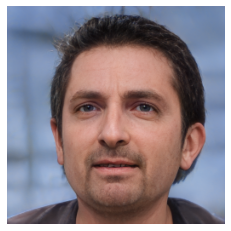

In [211]:
%matplotlib inline
# latent1_hy = hy_latent(latent_code[792])
lamda = 0.6

# randi = int(np.random.rand(1)*995)
# if 415==randi:
#     randi = randi-1 
# latent_rand = latent_code[randi]

latent_gt = latent_code[415]
latent_untar = lamda*latent_gt+(1-lamda)*latent_avg*latent_mask
input_latent = hy_latent(latent_untar)

# latent_tar = lamda*latent_gt+(1-lamda)*latent_rand*latent_mask
# input_latent = hy_latent(latent_tar)

# latent2_hy = hy_latent(latent2)

with torch.no_grad():
    result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)
        
result_image_temp = result_image_temp[0]
output_image_temp = tensor2im(result_image_temp)
res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
figsize = 4,4
figure, ax = plt.subplots(figsize=figsize)
plt.imshow(res_image_temp)
# plt.title('01220.png')
plt.axis('off')
plt.savefig('00415_06_u_ui.eps')

plt.show()


# Example images

# define evaluation tables

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import random
import copy
from skimage.metrics import structural_similarity as ssim
from numpy import linalg as LA
# from pytorch_fid import fid_score
from fid_score.fid_score import FidScore
from facenet_pytorch import MTCNN, InceptionResnetV1

resnet = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(image_size=256, margin=80)
sys.path.append("/home/csp-uts/Hanyu/facenet/src")
from face_ID_loss import load_and_align_data,clac_loss
import facenet

img_transforms = EXPERIMENT_ARGS['transform']
def hy_blur(img,blur_size):
    blur = cv2.blur(img,(blur_size,blur_size))
    return blur

def hy_mosaic(image,size):
    img = copy.copy(image)
    x,y,_ = img.shape
    for i in range(0,x-size,size):
        for j in range(0,y-size,size):
            img[i:i+size,j:j+size] = img[i+(size//2)][j+(size//2)]
    return img

            
def hy_L2(img,img_noise):
    a = img-img_noise
    b = a.flatten()
    L2_score = LA.norm(b)
    return L2_score

def hy_ALDp(img,img_noise):
    a = copy.copy(img)
    b = copy.copy(img_noise)
    c = a-b
    a1 = LA.norm(c[:,:,0], ord=np.inf)/LA.norm(a[:,:,0], ord=np.inf)
    a2 = LA.norm(c[:,:,1], ord=np.inf)/LA.norm(a[:,:,1], ord=np.inf)
    a3 = LA.norm(c[:,:,2], ord=np.inf)/LA.norm(a[:,:,2], ord=np.inf)
    ALDp_score = np.mean([a1,a2,a3])
    return ALDp_score
    
def hy_SSIM(img,img_noise):
    ssim_noise = ssim(img, img_noise,multichannel=True)
    return ssim_noise

def hy_FID():
    gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt'
    re_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
    paths = [gt_path,re_path]
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    batch_size = 1
    fid = FidScore(paths, device, batch_size)
    fidscore = fid.calculate_fid_score()
    return fidscore

def hy_MSapi(faceId1,res_image_g):
    faceId2 = find_faceID(res_image_g)
    result = isIdenticalll(faceid1=faceId1,faceid2=faceId2)
    if not 'isIdentical' in result.keys():
        return 0
    else:
        return result['confidence']


def hy_arcface(gt_image,res_image_g,gt_path):
    score_temp = id_loss_cal.extract_on_images(gt_image,res_image_g,gt_path)
    if score_temp == None:
        return 0
    else:
        ID_score = score_temp[os.path.basename(gt_path)]
        return ID_score


def hy_facenet(gt_path,data_path):
    img1 = Image.open(gt_path)
    img2 = Image.open(data_path)
    transformed_image1 = img_transforms(img1)
    transformed_image2 = img_transforms(img2)
    embedding1 = resnet(transformed_image1.unsqueeze(0))
    embedding2 = resnet(transformed_image2.unsqueeze(0))
    e1 = embedding1.detach().numpy()[0]
    e2 = embedding2.detach().numpy()[0]
    E = (e1-e2)
    facenet_score = LA.norm(E)
    return facenet_score

/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csp-uts/anaconda3/envs/Hanyu

# Un-Targeted Eva

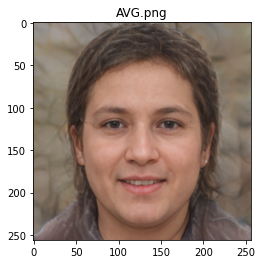

In [14]:
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)

latent_avg = np.mean(latent_code,axis=0)
latent1_hy = hy_latent(latent_avg)
with torch.no_grad():
    result_image_temp, latent_temp,codes_temp = run_on_gen(latent1_hy.unsqueeze(0), net)
        
result_image_temp = result_image_temp[0]
output_image_temp = tensor2im(result_image_temp)
res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
plt.imshow(res_image_temp)
plt.title('AVG.png')
plt.show()

In [90]:
# ------------------------------------------------------
#  load latent and image 
# ------------------------------------------------------
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)
latent_avg = np.mean(latent_code,axis=0)

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  Un-targeted method
# ------------------------------------------------------
    lamda = 0

    latent_gt = latent_code[i]
    latent_untar = lamda*latent_gt+(1-lamda)*latent_avg
    input_latent = hy_latent(latent_untar)

    with torch.no_grad():
        result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)

    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    # res_image_temp = Image.fromarray(np.array(output_image_temp))
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    res_image_temp.save(temp_path_data)


# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = np.array(output_image_temp.resize((256, 256)))
    
    l2_score = hy_L2(img,img_noise)
    l2_list.append(l2_score)

    
    aldp_score = hy_ALDp(img,img_noise)
    aldp_list.append(aldp_score)
    
    ssim_score = hy_SSIM(img,img_noise)
    ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
    fid_score = hy_FID()
    fid_list.append(fid_score)


    
    facenet_score = hy_facenet(temp_path_gt,temp_path_data)
    facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

l2_name = "l2_untar_"+str(int(lamda*100))+".npy"
aldp_name = "aldp_untar_"+str(int(lamda*100))+".npy"
ssim_name = "ssim_untar_"+str(int(lamda*100))+".npy"
arcface_name = "arcface_untar_"+str(int(lamda*100))+".npy"
fid_name = "fid_untar_"+str(int(lamda*100))+".npy"
facenet_name = "facenet_untar_"+str(int(lamda*100))+".npy"

np.save(l2_name,l2_list)
np.save(aldp_name,aldp_list)
np.save(ssim_name,ssim_list)
np.save(arcface_name,arcface_list)
np.save(fid_name,fid_list)
np.save(facenet_name,facenet_list)
        
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

Processing: 100.0% [995/995]


In [28]:
np.where(np.array(arcface_list)<0.3)

(array([  5,  49,  89, 106, 144, 192, 248, 288, 542, 588, 639, 655, 713,
        759, 845, 864]),)

lamda:::arcface_score   
[1 0.6161198817380709]  
[0.9 0.6022501923686745]  
[0.8 0.5731075084651235]  
[0.7 0.5294424128030712]  
[0.6 0.46991536264780476]  
[0.5 0.3977996115727191]     
[0.4 0.3167084975214909]    
[0.3 0.23219173175502736]    
[0.2 0.14925768845550827]  
[0.1 0.07726767504185289]  
[0 0.019505787818416505]  
[71455.8398711044 1.2814677500242835 0.40075672609970336 0.30826919881542725 221.46807832619282 0.8963123]  
[71791.05397604243 1.1620882498826846 0.5731414744903821 0.2579220111037244 287.26073353483747 1.0755435]




In [24]:
print(l2_avg, aldp_avg, ssim_avg, arcface_avg, fid_avg, facenet_avg)

73581.41047909697 1.2368438698500481 0.5488353178672577 0.6161309212521093 143.27988344342705 0.4540033


In [29]:
(995-16)/995

0.9839195979899498

# image plot

In [215]:
# tar
l2_tar = []
aldp_tar = []
ssim_tar = []
arcface_tar = []
fid_tar = []
facenet_tar = []

for i in range(10):
    lamda = i*0.1

    l2_name = "Latent_face_exps/l2_tar_"+str(int(lamda*100))+".npy"
    aldp_name = "Latent_face_exps/aldp_tar_"+str(int(lamda*100))+".npy"
    ssim_name = "Latent_face_exps/ssim_tar_"+str(int(lamda*100))+".npy"
    arcface_name = "Latent_face_exps/arcface_tar_"+str(int(lamda*100))+".npy"
    fid_name = "Latent_face_exps/fid_tar_"+str(int(lamda*100))+".npy"
    facenet_name = "Latent_face_exps/facenet_tar_"+str(int(lamda*100))+".npy"

    l2_list = np.load(l2_name)
    aldp_list = np.load(aldp_name)
    ssim_list = np.load(ssim_name)
    arcface_list = np.load(arcface_name)
    fid_list = np.load(fid_name)
    facenet_list = np.load(facenet_name)

    l2_avg = np.mean(l2_list)
    aldp_avg = np.mean(aldp_list)
    ssim_avg = np.mean(ssim_list)
    arcface_avg = np.mean(arcface_list)
    fid_avg = np.mean(fid_list)
    facenet_avg = np.mean(facenet_list)
    
    l2_tar.append(l2_avg)
    aldp_tar.append(aldp_avg)
    ssim_tar.append(ssim_avg)
    arcface_tar.append(arcface_avg)
    fid_tar.append(fid_avg)
    facenet_tar.append(facenet_avg)
    
#1 73581.40907296525 1.2368421317672496 0.5488353241091136 0.6161354111404574 143.2800664854719 0.45400342    
l2_tar.append(73581.40907296525)
aldp_tar.append(1.2368421317672496)
ssim_tar.append(0.5488353241091136)
arcface_tar.append(0.6161354111404574)
fid_tar.append(143.2800664854719)
facenet_tar.append(0.45400342)    

In [216]:
# untar
l2_untar = []
aldp_untar = []
ssim_untar = []
arcface_untar = []
fid_untar = []
facenet_untar = []

for i in range(11):
    lamda = i*0.1

    l2_name = "Latent_face_exps/l2_untar_"+str(int(lamda*100))+".npy"
    aldp_name = "Latent_face_exps/aldp_untar_"+str(int(lamda*100))+".npy"
    ssim_name = "Latent_face_exps/ssim_untar_"+str(int(lamda*100))+".npy"
    arcface_name = "Latent_face_exps/arcface_untar_"+str(int(lamda*100))+".npy"
    fid_name = "Latent_face_exps/fid_untar_"+str(int(lamda*100))+".npy"
    facenet_name = "Latent_face_exps/facenet_untar_"+str(int(lamda*100))+".npy"

    l2_list = np.load(l2_name)
    aldp_list = np.load(aldp_name)
    ssim_list = np.load(ssim_name)
    arcface_list = np.load(arcface_name)
    fid_list = np.load(fid_name)
    facenet_list = np.load(facenet_name)

    l2_avg = np.mean(l2_list)
    aldp_avg = np.mean(aldp_list)
    ssim_avg = np.mean(ssim_list)
    arcface_avg = np.mean(arcface_list)
    fid_avg = np.mean(fid_list)
    facenet_avg = np.mean(facenet_list)
    
    l2_untar.append(l2_avg)
    aldp_untar.append(aldp_avg)
    ssim_untar.append(ssim_avg)
    arcface_untar.append(arcface_avg)
    fid_untar.append(fid_avg)
    facenet_untar.append(facenet_avg)

In [134]:
print(l2_avg, aldp_avg, ssim_avg, arcface_avg, fid_avg, facenet_avg)

73416.53423554664 1.2561252500696656 0.5301937345022358 0.5928555441898616 148.38181140677935 0.48566326


# Untar
[0 68975.52287110561 1.2246596505011038 0.2991140337687989 0.019510394756462258 282.24912926711085 1.3139642]  
[0.1 69562.18304097 1.2408700456096522 0.32213261003149685 0.0772663219499603 268.6815325860815 1.235946]  
[0.2 70207.62942359266 1.2570777351184228 0.3476080453848082 0.14926316417968977 254.6520596473422 1.1346284]  
[0.3 70868.81279760604 1.2713380267541639 0.3749507457005752 0.23219855434153622 238.11995762978503 1.0114386]  
[0.4 71518.52251155008 1.2822430549686792 0.40367562395699025 0.31672390662508093 219.42946036568003 0.8839781]  
[0.5 72112.82512088472 1.2885457192846985 0.4331675416697728 0.3977663248655709 199.80939039515474 0.7668739]  
[0.6 72625.29045220712 1.2902019030959544 0.4626888742946984 0.4699200233229291 181.69575793307385 0.6634881]  
[0.7 73034.85489274304 1.2853635541434802 0.49149058335898915 0.5294427915396702 166.39837559475845 0.57884824]  
[0.8 73335.14219959806 1.2735542062047942 0.5177321031543051 0.5730905501162586 154.50595514539953 0.5144778]  
[0.9 73518.76305653596 1.2545059215479286 0.5385404820151872 0.602246475015678 146.9310627748069 0.47242573]  
[1 73581.40907296525 1.2368421317672496 0.5488353241091136 0.6161354111404574 143.2800664854719 0.45400342]   

# Tar
[0 66468.40382726057 1.1722542679613024 0.24398916704632762 0.008866999365258307 303.79686344215406 1.2766393]  
[0.1 66738.76084613157 1.1829988184588847 0.26172015459068765 0.03315923781503909 290.9229974590681 1.2460905]  
[0.2 67808.75195844275 1.2008989899131166 0.2826196096052395 0.06853963985744321 278.3148155991362 1.2021582]  
[0.3 68220.0253592157 1.2115005364128397 0.3065077663697549 0.11652920601150049 263.8888848323835 1.1494908]  
[0.4 68973.66892465123 1.2328222929225567 0.33784856027120735 0.1783905108248693 240.46005236095172 1.0466439]  
[0.5 70057.14912746534 1.2520299153176697 0.37161069662584595 0.2611192944052456 224.14642555520854 0.9395062]  
[0.6 70910.25993288805 1.2607305456381237 0.4150257107503414 0.3564824265601048 197.02595302596936 0.8072549]  
[0.7 71872.83378281402 1.2741206138646117 0.45341292811199085 0.45717239018960215 175.31861415569213 0.67516744]  
[0.8 72551.58369466575 1.2694840917371728 0.49366083466459554 0.5396086411316641 158.47032523434981 0.5556684]  
[0.9 73416.53423554664 1.2561252500696656 0.5301937345022358 0.5928555441898616 148.38181140677935 0.48566326]  
[1 73581.40907296525 1.2368421317672496 0.5488353241091136 0.6161354111404574 143.2800664854719 0.45400342]  

In [186]:
lamda = 0.9

arcface_name = "Latent_face_exps/arcface_tar_"+str(int(lamda*100))+".npy"

arcface_list = np.load(arcface_name)

FPPRS_length = len(np.where(arcface_list>0.3)[0])
FPPRS_length/995

0.9829145728643216

In [56]:
# FFPRS Untar
FPP_Untar = [0,0.004020100502512563,0.03015075376884422,0.21407035175879396,0.5939698492462312,0.8472361809045226,0.942713567839196,0.9698492462311558,0.9768844221105528,0.9839195979899498,0.9839195979899498]

# TAR
FPP_Tar = [0.0020100502512562816,0.0020100502512562816,0.006030150753768844,0.019095477386934675,0.09447236180904522,0.3407035175879397,0.7306532663316583,0.9206030150753769,0.9668341708542714,0.9829145728643216,0.9839195979899498]

In [63]:
FPP_1 = np.ones(11)-FPP_Untar
FPP_2 = np.ones(11)-FPP_Tar

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


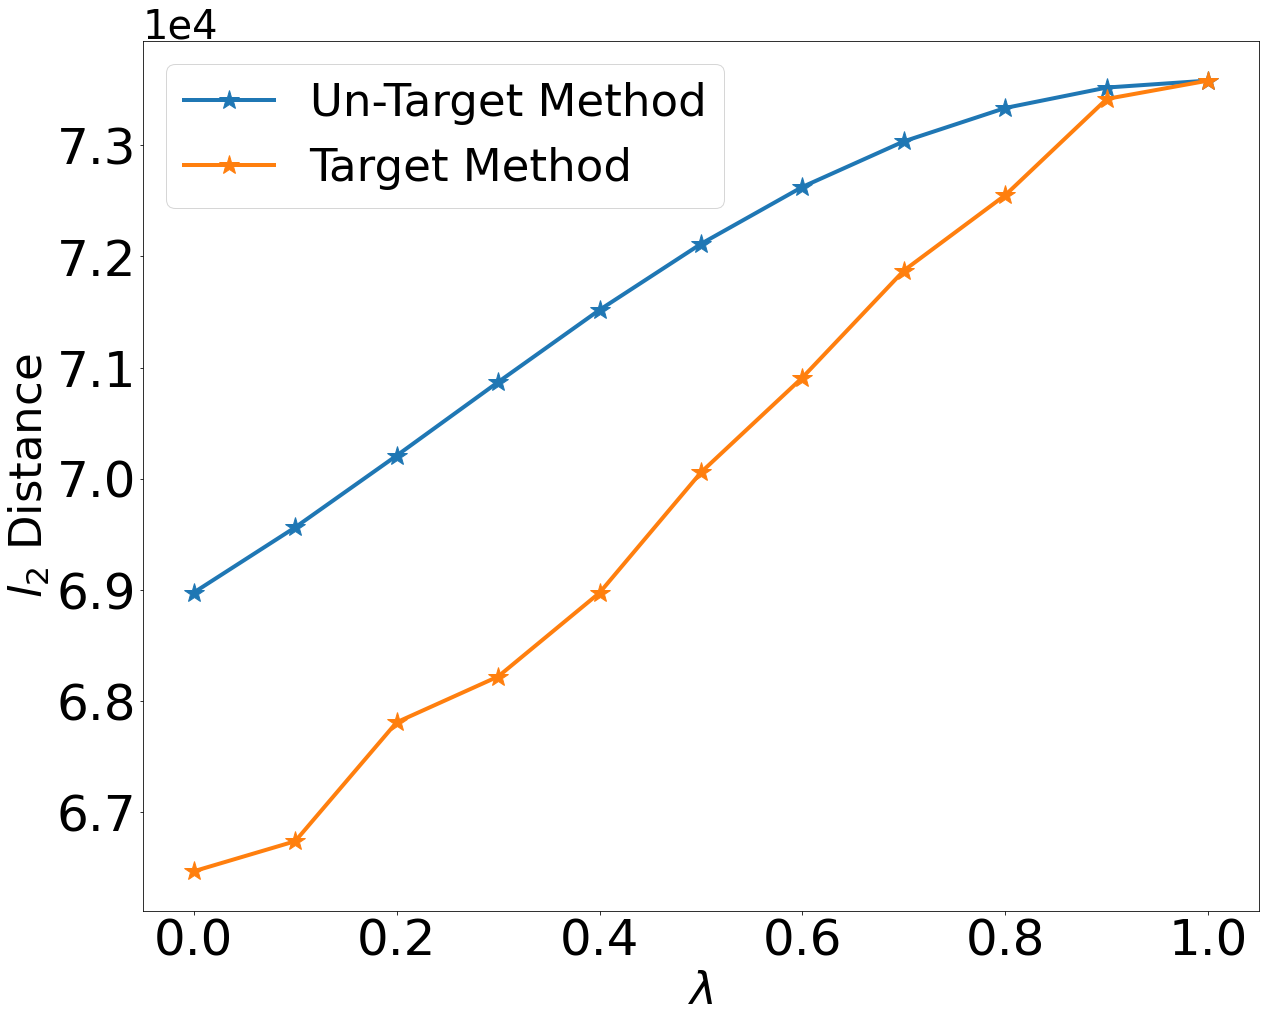

In [240]:
%matplotlib inline
import matplotlib

figsize = 20,16
matplotlib.rcParams.update({'font.size':40, 'font.family':'Times New Roman'}) # set param font
figure, ax = plt.subplots(figsize=figsize)
x = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
y_utar = [0.019505787818416505,0.07726767504185289,0.14925768845550827,0.23219173175502736,0.3167084975214909,0.3977996115727191,0.46991536264780476,0.5294424128030712,0.5731075084651235,0.6022501923686745,0.6161198817380709]  
y_tar = [0.011271837113153695,0.02782221515171567,0.06283397181567985,0.11395710057499421,0.18118346338464536,0.2619505709842147,0.3551242196679714,0.45658829883208973,0.539465041554079,0.5938880742476065,0.6161198817380709]

plt.plot(x,l2_untar,linewidth=4, markersize=20,marker='*')
plt.plot(x,l2_tar,linewidth=4, markersize=20,marker='*')

# set axis number limits
ax = plt.gca()
ax.yaxis.get_major_formatter().set_powerlimits((0,1))


#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 45,
}
legend = plt.legend(["Un-Target Method","Target Method"],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=50)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 45,
}
plt.xlabel('$\lambda$',font2)
plt.ylabel("$l_2$ Distance",font2)
 
#将文件保存至文件中并且画出图
plt.savefig('l2.eps')
plt.show()


# target

In [33]:
int(np.random.rand(1)*995)

734

In [91]:
# ------------------------------------------------------
#  load latent and image 
# ------------------------------------------------------
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)
# latent_avg = np.mean(latent_code,axis=0)

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    randi = int(np.random.rand(1)*995)
    if i==randi:
        randi = randi-1 
    latent_rand = latent_code[randi]
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  targeted method
# ------------------------------------------------------
    lamda = 0

    latent_gt = latent_code[i]
    latent_tar = lamda*latent_gt+(1-lamda)*latent_rand
    input_latent = hy_latent(latent_tar)

    with torch.no_grad():
        result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)

    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    # res_image_temp = Image.fromarray(np.array(output_image_temp))
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    res_image_temp.save(temp_path_data)


# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = np.array(output_image_temp.resize((256, 256)))
    
    l2_score = hy_L2(img,img_noise)
    l2_list.append(l2_score)

    
    aldp_score = hy_ALDp(img,img_noise)
    aldp_list.append(aldp_score)
    
    ssim_score = hy_SSIM(img,img_noise)
    ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
    fid_score = hy_FID()
    fid_list.append(fid_score)


    
    facenet_score = hy_facenet(temp_path_gt,temp_path_data)
    facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

l2_name = "l2_tar_"+str(int(lamda*100))+".npy"
aldp_name = "aldp_tar_"+str(int(lamda*100))+".npy"
ssim_name = "ssim_tar_"+str(int(lamda*100))+".npy"
arcface_name = "arcface_tar_"+str(int(lamda*100))+".npy"
fid_name = "fid_tar_"+str(int(lamda*100))+".npy"
facenet_name = "facenet_tar_"+str(int(lamda*100))+".npy"

np.save(l2_name,l2_list)
np.save(aldp_name,aldp_list)
np.save(ssim_name,ssim_list)
np.save(arcface_name,arcface_list)
np.save(fid_name,fid_list)
np.save(facenet_name,facenet_list)

l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

Processing: 100.0% [995/995]


In [61]:
print(l2_avg, aldp_avg, ssim_avg, arcface_avg, fid_avg, facenet_avg)

70065.18901091613 1.2532290948487672 0.3884737340051922 0.2958596310536167 213.81366667985435 0.8888592


lamda:::arcface_score   
[1 0.6161198817380709]  
[0.9 0.5938880742476065]  
[0.8 0.539465041554079]  
[0.7 0.45658829883208973]  
[0.6 0.3551242196679714]
[0.55 70258.84186967042 1.2554472935492964 0.39056632463090235 0.31008284143336007 209.12779057052802 0.8718506]
[0.54 70065.18901091613 1.2532290948487672 0.3884737340051922 0.2958596310536167 213.81366667985435 0.8888592]
[0.5 0.2619505709842147]     
[0.4 0.18118346338464536]
[0.39 68887.45221930428 1.2295222663610152 0.33352982985868046 0.17220820797672823 244.0755558852635 1.0617757]
[0.3 0.11395710057499421]    
[0.2 0.06283397181567985]  
[0.1 0.02782221515171567]  
[0 0.011271837113153695]

[71455.8398711044 1.2814677500242835 0.40075672609970336 0.30826919881542725 221.46807832619282 0.8963123]  
[71791.05397604243 1.1620882498826846 0.5731414744903821 0.2579220111037244 287.26073353483747 1.0755435]




# Blur

In [48]:
# ------------------------------------------------------
#  load image 
# ------------------------------------------------------

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  blur
# ------------------------------------------------------
    blur = hy_blur(img,19)
    res_image_temp = Image.fromarray(blur)
    res_image_temp.save(temp_path_data)


# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = blur
    
#     l2_score = hy_L2(img,img_noise)
#     l2_list.append(l2_score)

    
#     aldp_score = hy_ALDp(img,img_noise)
#     aldp_list.append(aldp_score)
    
#     ssim_score = hy_SSIM(img,img_noise)
#     ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
#     fid_score = hy_FID()
#     fid_list.append(fid_score)


    
#     facenet_score = hy_facenet(temp_path_gt,temp_path_data)
#     facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

    
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

Processing: 100.0% [995/995]


In [49]:
print(l2_avg, aldp_avg, ssim_avg, arcface_avg, fid_avg, facenet_avg)

nan nan nan 0.3144314147045265 nan nan


In [54]:
np.shape(np.where(np.array(arcface_list)>0.3))

(1, 563)

# Mosaic

In [ ]:
# ------------------------------------------------------
#  load latent and image 
# ------------------------------------------------------
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  mosaic
# ------------------------------------------------------
    mosaic = hy_mosaic(img,8)
    res_image_temp = Image.fromarray(mosaic)
    res_image_temp.save(temp_path_data)

# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = mosaic
    
    l2_score = hy_L2(img,img_noise)
    l2_list.append(l2_score)

    
    aldp_score = hy_ALDp(img,img_noise)
    aldp_list.append(aldp_score)
    
    ssim_score = hy_SSIM(img,img_noise)
    ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
    fid_score = hy_FID()
    fid_list.append(fid_score)


    
    facenet_score = hy_facenet(temp_path_gt,temp_path_data)
    facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

    
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

In [ ]:
print(l2_avg, aldp_avg, ssim_avg, arcface_avg, fid_avg, facenet_avg)